In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io

pd.set_option("display.max_colwidth", None)

from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [6]:
df_ = pd.read_excel('Kaggle_Dataset/Global_Dataset.xlsx', usecols=['SEVERITY', 'DESCRIPTION'])
df = df_.copy()
df.head()

,SEVERITY,DESCRIPTION
0,MEDIUM,ip_input.c in BSD-derived TCP/IP implementations allows remote attackers to cause a denial of service (crash or hang) via crafted packets.
1,HIGH,"Buffer overflow in NFS mountd gives root access to remote attackers, mostly in Linux systems."
2,HIGH,Execute commands as root via buffer overflow in Tooltalk database server (rpc.ttdbserverd).
3,MEDIUM,"MIME buffer overflow in email clients, e.g. Solaris mailtool and Outlook."
4,HIGH,Arbitrary command execution via IMAP buffer overflow in authenticate command.


In [7]:
def df_stats(data):
    bold(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLS: {}".format(data.shape[1]))
    bold(" TYPES ".center(50, "#"))
    print(data.dtypes)
    bold(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    bold(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    #bold(" DESCRIBE ".center(50, "#"))
    #print(data.describe().T)
    bold(" MEMORY USAGE ".center(50, "#"))
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))

In [8]:
df_stats(df)

**##################### SHAPE ######################**

ROWS: 169566
COLS: 2


**##################### TYPES ######################**

SEVERITY       object
DESCRIPTION    object
dtype: object


**################# MISSING VALUES #################**

SEVERITY       86
DESCRIPTION     0
dtype: int64


**############### DUPLICATED VALUES ################**

NUMBER OF DUPLICATED VALUES: 7748


**################## MEMORY USAGE ##################**

Memory Usage: 2.6+ MB


In [9]:
df = df.dropna()

<Axes: ylabel='count'>

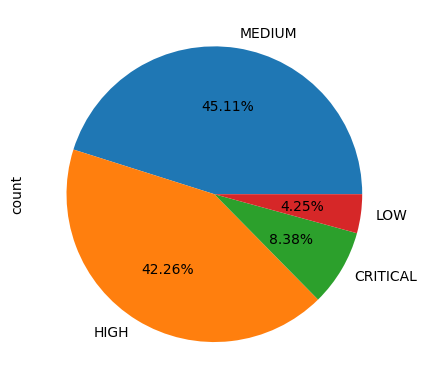

In [10]:
df["SEVERITY"].value_counts().plot(kind="pie", autopct="%.2f%%")

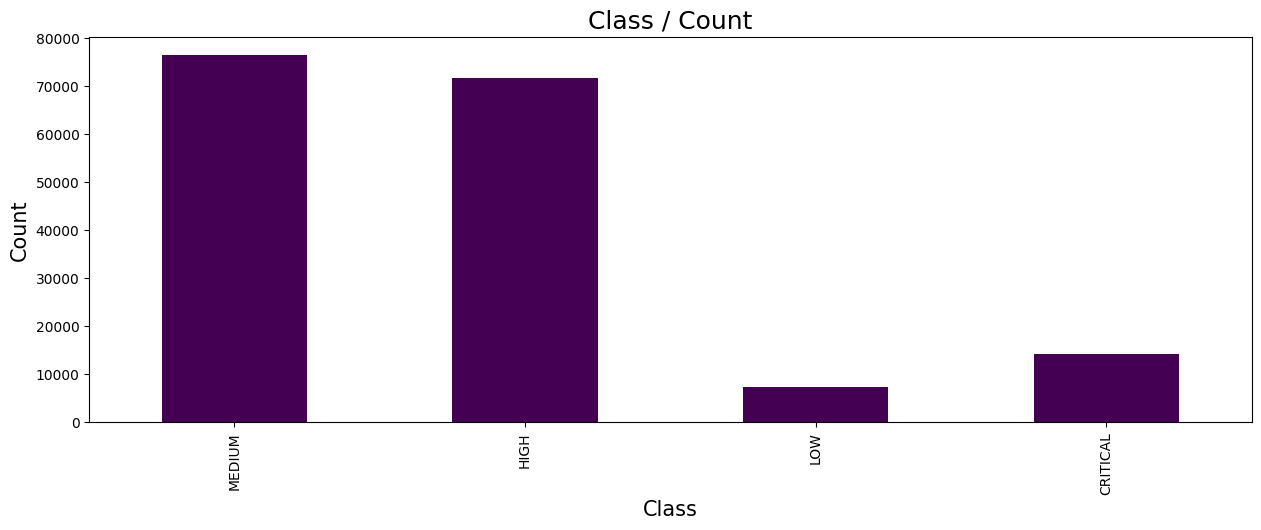

In [11]:
tags = Counter(df["SEVERITY"]).keys()
tags_len = Counter(df["SEVERITY"]).values()
tag_df = pd.DataFrame(zip(tags, tags_len), columns=["Class", "Count"])
tag_df.plot(x="Class", y="Count", kind="bar", legend=False, grid=False, figsize=(15, 5), cmap='viridis')
plt.title("Class / Count", fontsize=18)
plt.xlabel("Class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

In [12]:


def word_freq(data, label, target, text, title):
    freq_df = data[data[target] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

[nltk_data] Downloading package punkt to C:\Users\lenovo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


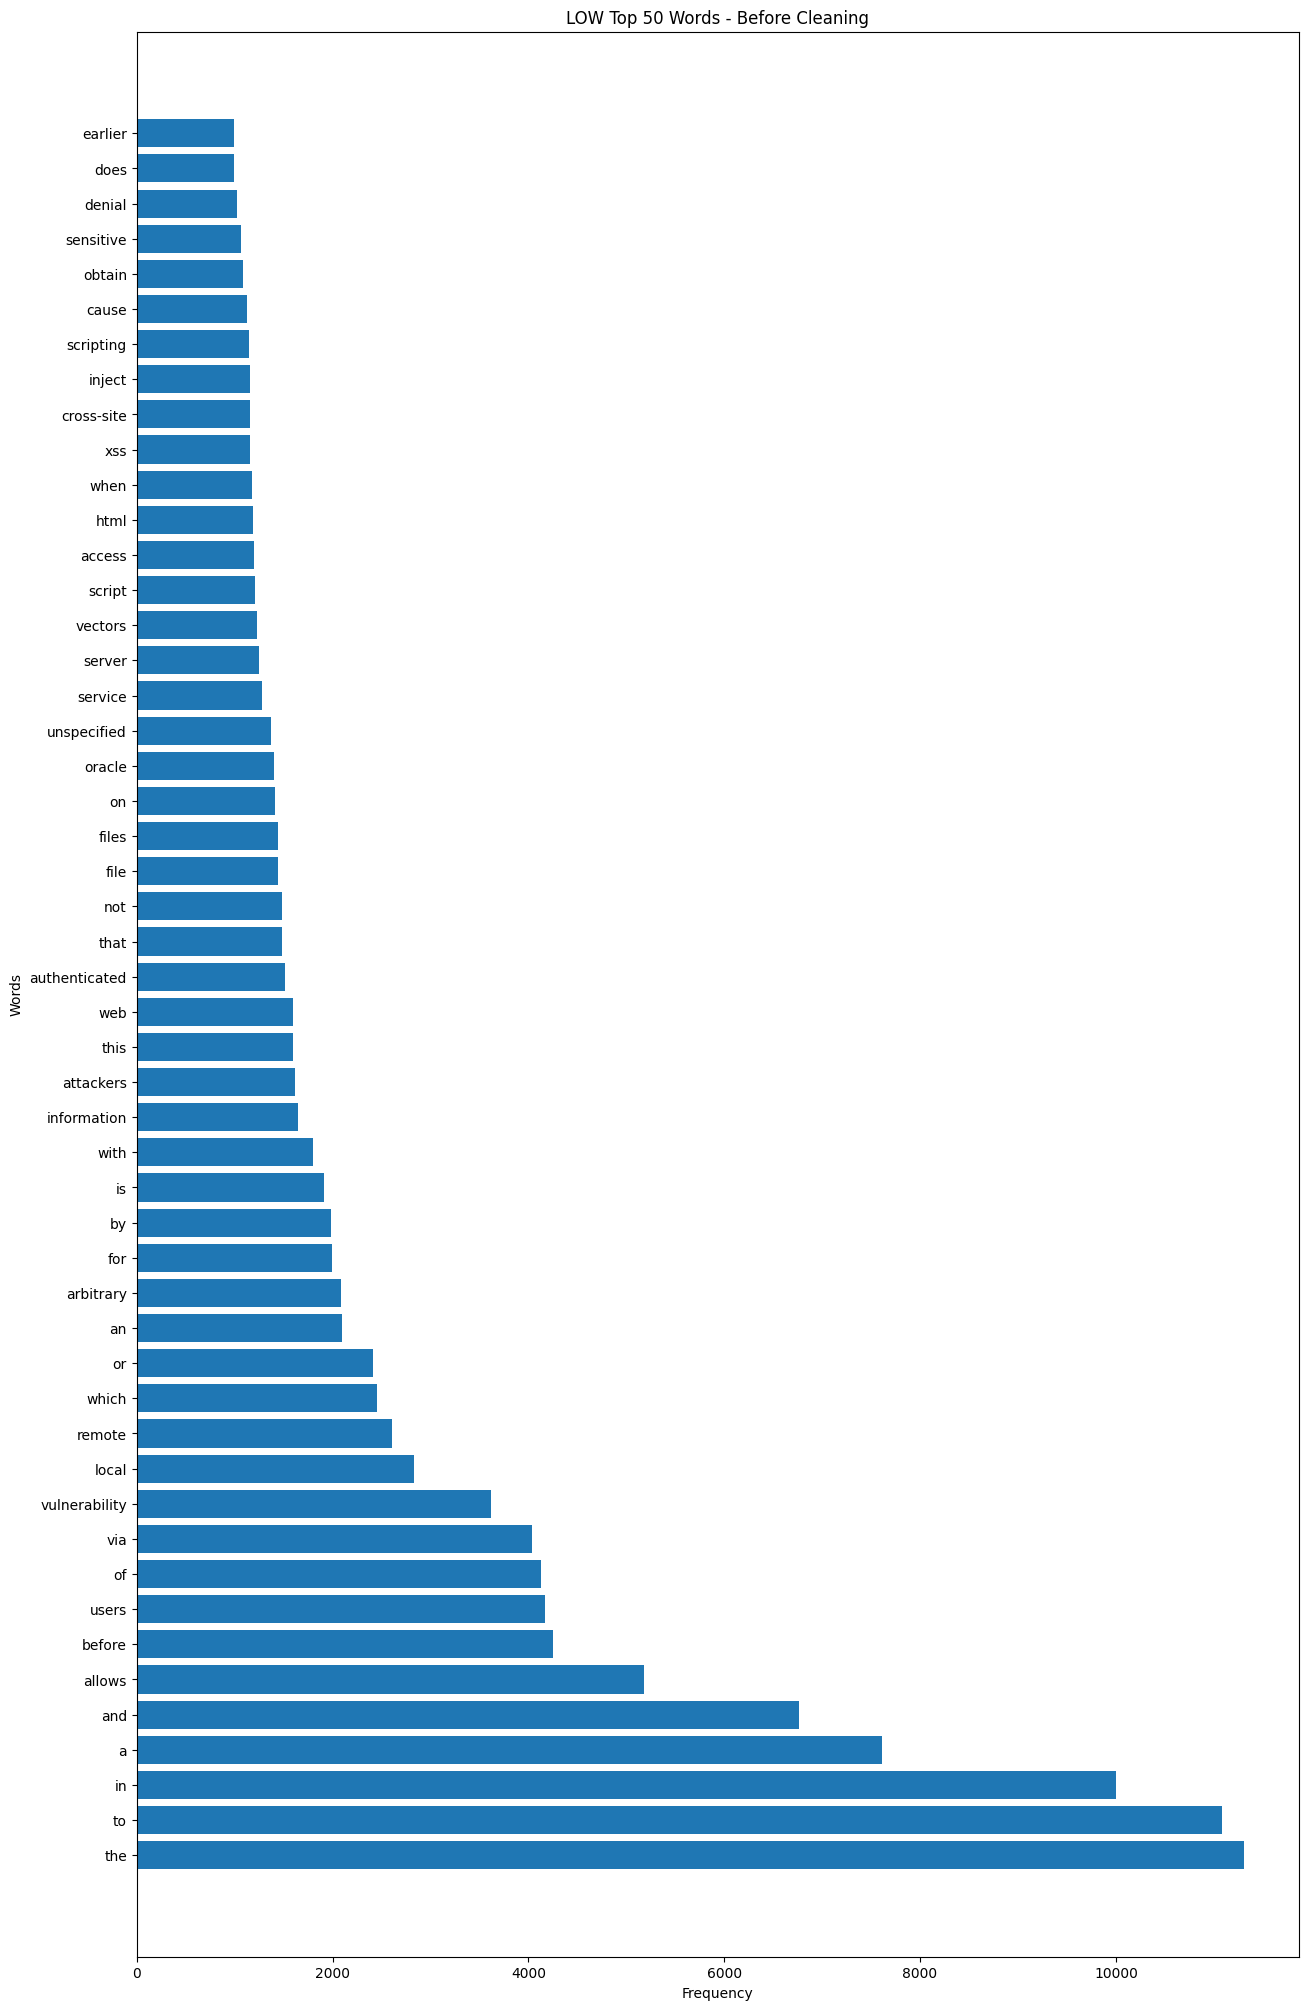

In [15]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

ham_low_top = word_freq(df, 'LOW', "SEVERITY", "DESCRIPTION", "LOW Top 50 Words - Before Cleaning")